# Прогнозирование оплаты клиента. Тестовое задание

## Загрузка данных

Нам понадобятся следующие библиотеки для дальнейшей работы:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

Читаем данные с помощью метода pandas и выведем первые строки, чтобы убедиться в качественной загрузке. Также посмотрим общую информацию о странице, может быть в данных будут пропуски или неправильный тип столбцов.

In [2]:
data = pd.read_excel('C:/Users/79283/Desktop/fifthTask.xlsm')
data.head()

,ID,CONTRACT,TOTAL_SUM,DEBT_SUM,BIG_BALANCE,IS_BAIL,MOB_CREDIT_DATE,COUNT_REFUSE,COUNT_OO,PAID_1_MONTHS_AGO,PAID_2_MONTHS_AGO,PAID_3_MONTHS_AGO,WILL_PAY
0,1384,12545,48855.77,48855.77,0,0,11,0,0,0,0,0,0
1,1385,12793,31483.46,31483.46,0,1,22,0,0,0,0,0,1
2,1386,15836,32837.34,32837.34,0,0,20,0,0,0,0,0,0
3,1387,12716,67454.02,9041.22,0,0,66,0,0,0,0,1,0
4,1388,21281,50071.92,50071.92,0,0,9,1,0,0,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 1000 non-null   int64  
 1   CONTRACT           1000 non-null   int64  
 2   TOTAL_SUM          1000 non-null   float64
 3   DEBT_SUM           1000 non-null   float64
 4   BIG_BALANCE        1000 non-null   int64  
 5   IS_BAIL            1000 non-null   int64  
 6   MOB_CREDIT_DATE    1000 non-null   int64  
 7   COUNT_REFUSE       1000 non-null   int64  
 8   COUNT_OO           1000 non-null   int64  
 9   PAID_1_MONTHS_AGO  1000 non-null   int64  
 10  PAID_2_MONTHS_AGO  1000 non-null   int64  
 11  PAID_3_MONTHS_AGO  1000 non-null   int64  
 12  WILL_PAY           1000 non-null   int64  
dtypes: float64(2), int64(11)
memory usage: 101.7 KB


Выведем информацию о столбцах:

*   ID – Идентификатор 
* 	CONTRACT – Номер договора
*	TOTAL_SUM –  Итоговая сумма необходимая к погашению, руб
*	DEBT_SUM –  Просроченная сумма необходимая к погашению, руб
*	BIG_BALANCE  –  Большой баланс ( 1 - START_SUM >100000, 0 – иначе)
*	IS_BAIL  - Является ли продукт залоговым (1-залоговый, 0 – нет)
*	MOB_CREDIT_DATE – Количество месяцев, прошедших с даты выдачи кредита 
*	COUNT_REFUSE – Количество отказов от оплаты за последний месяц 
*	COUNT_OO – Количество обещаний оплаты за последний месяц
*	PAID_1_MONTHS_AGO – Платил 1 месяц назад 
*	PAID_2_MONTHS_AGO – Платил 2 месяца назад
*	PAID_3_MONTHS_AGO– Платил 3 месяца назад 
*	WILL_PAY – Поступит ли оплата в течение 30 дней – метка класса 


Изменим названия столбцов на нижний регистр, чтобы было удобнее работать с ними.

In [4]:
data.columns = ['id', 'contract', 'total_sum', 'debt_sum', 'big_balance', 'is_bail', 'mob_credit_date',
               'count_refuse', 'count_oo', 'paid_1_months_ago', 'paid_2_months_ago', 'paid_3_months_ago', 'will_pay']
data.columns

Index(['id', 'contract', 'total_sum', 'debt_sum', 'big_balance', 'is_bail',
       'mob_credit_date', 'count_refuse', 'count_oo', 'paid_1_months_ago',
       'paid_2_months_ago', 'paid_3_months_ago', 'will_pay'],
      dtype='object')

## Проверка признаков. Подготовка данных

Наш целевой признак - **will_pay**. Далее мы будем делить данные на выборки, и необходимо удостовериться что в целевом признаке нету сильного дисбаланса классов.

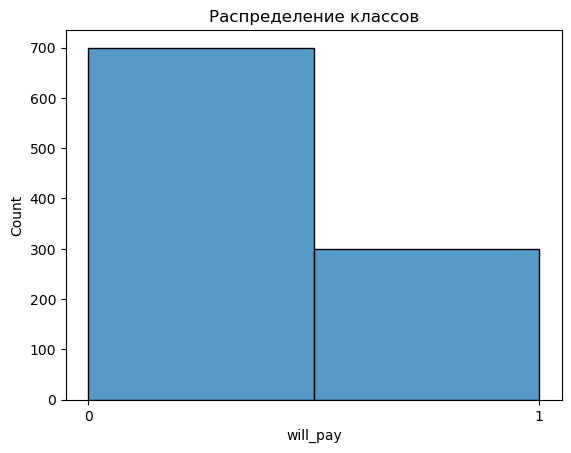

In [5]:
def check_class_balance(data):
    plt.xticks([0,1])
    plt.title('Распределение классов')
    sns.histplot(data=data['will_pay'], bins=2)
    
check_class_balance(data)

Различие не критично, главное следить за тем чтобы в тренировочной выборке было примерно такое же распределение. Удалим очевидно мешающие столбцы: ID, CONTRACT. И разделим на обучающую, валидационную и тестовую выборки в пропорции 60:20:20

In [6]:
data = data.drop(['id', 'contract'], axis=1)

In [7]:
train, test = train_test_split(data, test_size=0.2, random_state=123)
train, valid = train_test_split(train, test_size=0.25, random_state=123)

train_X = train.drop('will_pay', axis=1)
train_y = train['will_pay']

valid_X = valid.drop('will_pay', axis=1)
valid_y = valid['will_pay']

test_X = test.drop('will_pay', axis=1)
test_y = test['will_pay']

print('Обучающий набор -', train_X.shape)
print('Валидационный набор -', valid_X.shape)
print('Тестовый набор -', test_X.shape)

Обучающий набор - (600, 10)
Валидационный набор - (200, 10)
Тестовый набор - (200, 10)


Теперь проверим распределение в тренировочной выборке.

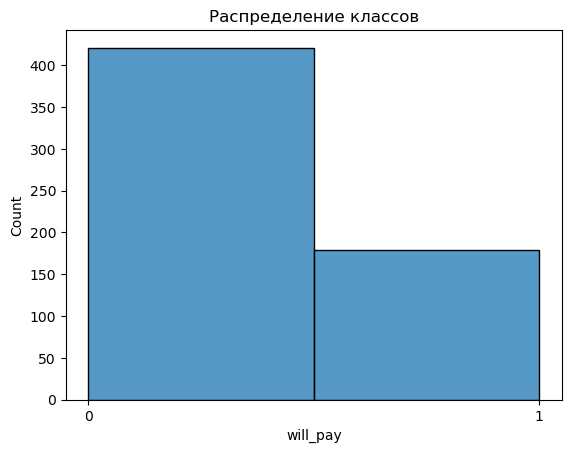

In [8]:
check_class_balance(train)

Баланс сохранился.

Видно, что в значениях столбцов очень сильно разнится размерность значений, это мешает модели правильно расценить важность признаков, поэтому необходимо провести стандартизацию данных.

In [9]:
scaler = StandardScaler()
scaler.fit(train_X)

train_X = pd.DataFrame(columns=data.drop('will_pay', axis=1).columns,
                       data=scaler.transform(train_X))
valid_X = pd.DataFrame(columns=data.drop('will_pay', axis=1).columns,
                       data=scaler.transform(valid_X))
test_X = pd.DataFrame(columns=data.drop('will_pay', axis=1).columns,
                       data=scaler.transform(test_X))

train_X.head()

,total_sum,debt_sum,big_balance,is_bail,mob_credit_date,count_refuse,count_oo,paid_1_months_ago,paid_2_months_ago,paid_3_months_ago
0,0.177707,0.509726,1.665408,-0.422826,0.763557,-0.301941,-0.338128,-0.409042,-0.497394,-0.590182
1,2.362520,-0.352087,1.665408,2.365038,-1.515471,-0.301941,-0.338128,-0.409042,-0.497394,-0.590182
2,-0.464333,-0.243380,-0.600453,-0.422826,-0.475045,-0.301941,-0.338128,-0.409042,-0.497394,-0.590182
3,-0.615709,-0.420943,-0.600453,-0.422826,-1.218207,-0.301941,0.848285,2.444738,2.010477,1.694393
4,-0.636104,-0.444866,-0.600453,-0.422826,0.466292,-0.301941,-0.338128,-0.409042,-0.497394,-0.590182


Теперь оценим как сильно признаки влияют друг на друга, возможно мы выявим мультиколлинеарность. Но также мы найдем бесполезные и полезные столбцы.

interval columns not set, guessing: ['total_sum', 'debt_sum', 'big_balance', 'is_bail', 'mob_credit_date', 'count_refuse', 'count_oo', 'paid_1_months_ago', 'paid_2_months_ago', 'paid_3_months_ago', 'will_pay']


<AxesSubplot:>

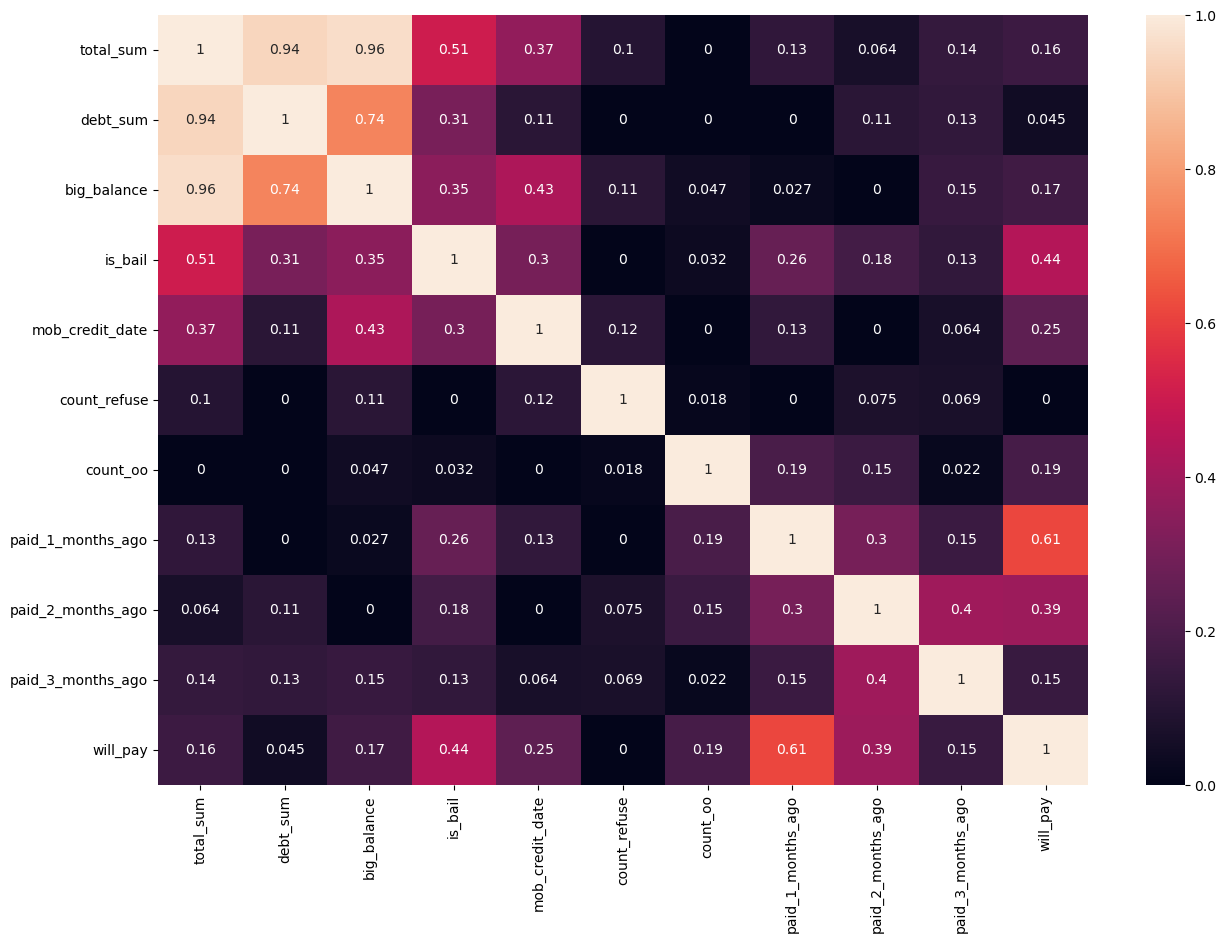

In [10]:
plt.figure(figsize=(15,10))
sns.heatmap(data.phik_matrix(), annot=True)

Значения в ячейках показывают насколько сильно два признака влияют друг на друга. Соответственно большой баланс и сумма долга прямо влияют на значение итоговой суммы к погашению и наоборот. Нам интересно сейчас увидеть влияние на will_pay.

* Факт оплаты какое то время назад имеет значительный вес. И чем меньше времени прошло с момента оплаты, тем больше полезной информации для нашего целевого признака.
* Факт залогового продукта значительно влияет на шанс оплаты.
* Количество обещаний, количество месяцев прошедших с оплаты, наличие большого баланса и общая сумма к погашению имеет свой вес.
* Количество отказов от оплаты, сумма долга - совсем или практически не влияют на шанс оплаты долга. Более того сумма долга очень сильно влияет на большой баланс и общую сумму, что нежелательно.

Удалим выявленные ненужные столбцы.

In [11]:
train_X = train_X.drop(['count_refuse', 'debt_sum'], axis=1)
valid_X = valid_X.drop(['count_refuse', 'debt_sum'], axis=1)
test_X = test_X.drop(['count_refuse', 'debt_sum'], axis=1)

train_X.head()

,total_sum,big_balance,is_bail,mob_credit_date,count_oo,paid_1_months_ago,paid_2_months_ago,paid_3_months_ago
0,0.177707,1.665408,-0.422826,0.763557,-0.338128,-0.409042,-0.497394,-0.590182
1,2.362520,1.665408,2.365038,-1.515471,-0.338128,-0.409042,-0.497394,-0.590182
2,-0.464333,-0.600453,-0.422826,-0.475045,-0.338128,-0.409042,-0.497394,-0.590182
3,-0.615709,-0.600453,-0.422826,-1.218207,0.848285,2.444738,2.010477,1.694393
4,-0.636104,-0.600453,-0.422826,0.466292,-0.338128,-0.409042,-0.497394,-0.590182


Мы отобрали 8 признаков, которые должны быть полезны нашей будущей модели. Также мы провели стандартизацию, и учли баланс классов. Можно переходить к построению модели.

Но перед этим можно посмотреть на портрет платящего и неплатящего клиента. Кто он и какие у него характеристики.

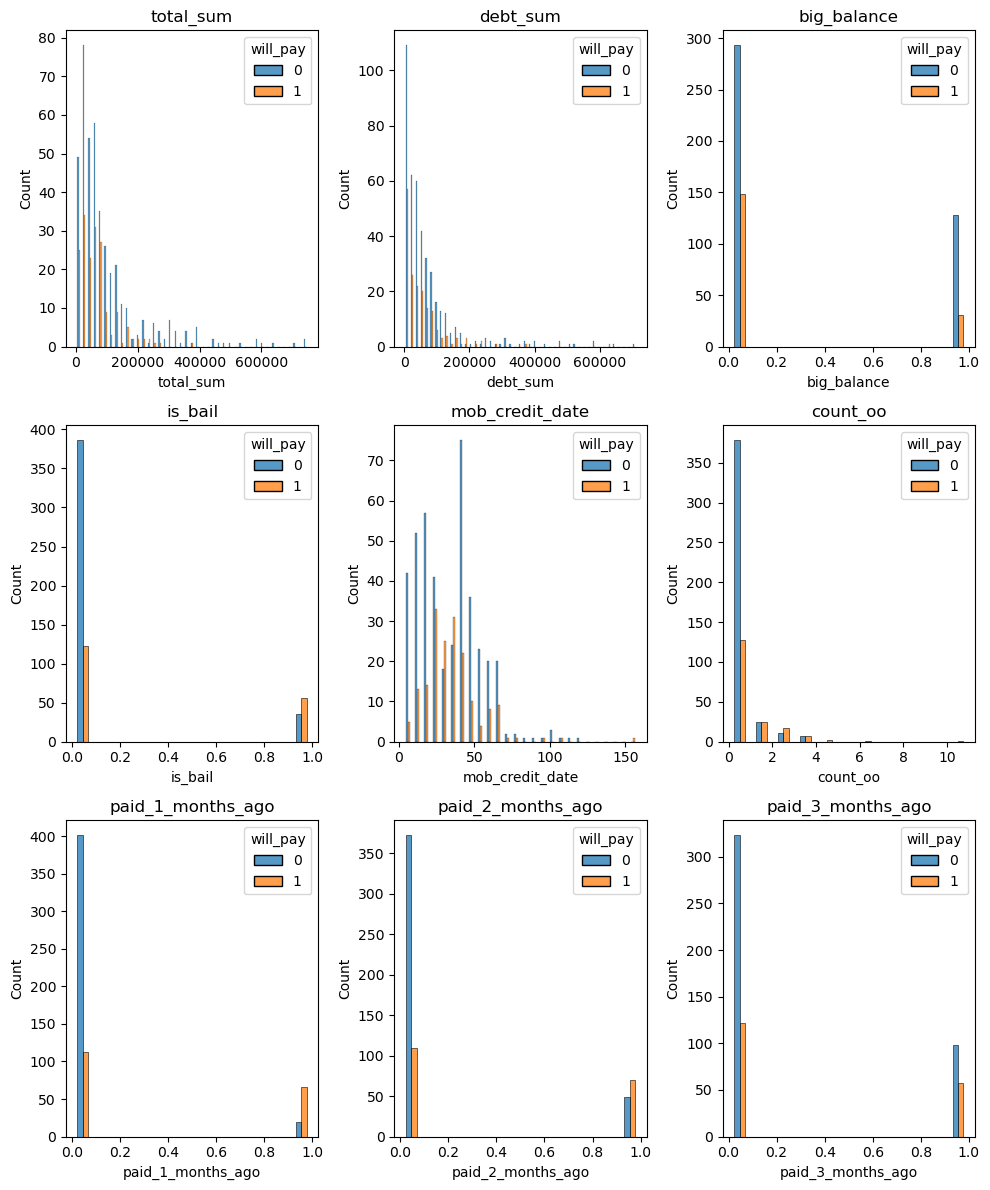

In [29]:
plt.figure(figsize=(10,12))
for i in range(len(train.drop(['count_refuse', 'debt_sum'], axis=1).columns)):
    plt.subplot(3,3,i+1)
    sns.histplot(data=train, 
                 x=train.drop(['count_refuse'], axis=1).columns[i], 
                 hue='will_pay', 
                 multiple='dodge', 
                 shrink=0.5)
    plt.tight_layout()
    plt.title(train.drop(['count_refuse'], axis=1).columns[i])
plt.show()

Мы можем сделать следующие выводы:
1. Когда продукт залоговый, люди с гораздо большей вероятностью оплачивают долг.
2. Если человек платил один-два месяца назад, то есть средняя вероятность что он оплатит долг.
3. Если человек обещает выплату больше чем 1 раз, есть средняя вероятность что он действительно заплатит.
4. Подавляющее большинство кредитов оплачивается к 70-ти месяцам.

Переходим к модели.

## Построение и обучение модели

Используем три типа модели и выберем лучшую из них:
1. Логистическая регрессия
2. RandomForestClassifier
3. CatBoost

Использовать будем следующие метрики:

1. Метрика f1 равна среднему гармоническому от точности и полноты. 
    * Полнота может позволить правильно определить **всех** действительно платящих клиентов, но поверх этого добавит нулей в единицы, что даст завышенный показатель. Для решения этого стоит смотреть на точность.
    * Точность покажет нам как много неплатящих клиентов модель посчитала за платящих. При хорошей точности, модель может множество единиц посчитать за нули. По итогу мы получим заниженный реальный показатель платящих.

    Поэтому мы больше уделим внимание общей метрике - f1, который покажет некий средний результат.
    
2. ROC-AUC - это площадь под кривой roc. Кривая представляет из себя линию от (0,0) до (1,1) в координатах True Positive Rate и False Positive Rate. TPR - это полнота, а FPR показывает, какую долю из класса 0 модель предсказала неверно и присвоила им 1.

    Смотря на эти две метрики, мы модель которая лучше всего будет классифицировать клиентов.


In [24]:
def get_result(y_true, y_preds, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)

    plt.figure(figsize=(6,3.5))
    plt.grid(True)
    plt.xticks(np.arange(0,1.01,0.1))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle='--') 
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC-кривая')
    
    print('ROC-AUC score =', roc_auc_score(y_true, y_probs))
    print('F1 score =', f1_score(y_true, y_preds))
    
    print('''|---------|---------|--------|--------|
|threshold|precision| recall |f1_score|
|---------|---------|--------|--------|''')
    for threshold in np.arange(0.1,0.9,0.1):
        new_preds = [1. if x >= threshold else 0. for x in y_probs]
        print('|{:^9.2}|{:^9.3}|{:^8.3}|{:^8.4}|'.format(threshold, 
                                                       precision_score(y_true, new_preds), 
                                                       recall_score(y_true, new_preds),
                                                       f1_score(y_true, new_preds)))
    print('|---------|---------|--------|--------|')

Функция выше выводит метрики, которые мы выбрали, а также roc кривую и пороги, среди которых можно будет использовать наилучший.

### LogisticRegression

ROC-AUC score = 0.8844086021505377
F1 score = 0.6842105263157896
|---------|---------|--------|--------|
|threshold|precision| recall |f1_score|
|---------|---------|--------|--------|
|   0.1   |  0.488  | 0.952  | 0.6448 |
|   0.2   |  0.649  | 0.806  | 0.7194 |
|   0.3   |  0.667  | 0.774  | 0.7164 |
|   0.4   |  0.677  |  0.71  | 0.6929 |
|   0.5   |  0.75   | 0.629  | 0.6842 |
|   0.6   |  0.818  | 0.581  | 0.6792 |
|   0.7   |  0.824  | 0.452  | 0.5833 |
|   0.8   |  0.818  |  0.29  | 0.4286 |
|---------|---------|--------|--------|


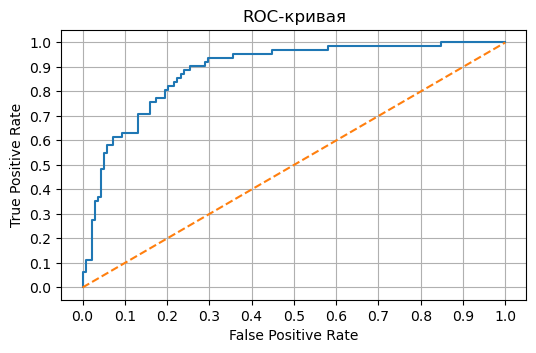

In [14]:
lg = LogisticRegression()
lg.fit(train_X, train_y)
preds = lg.predict(valid_X)
pred_probs = lg.predict_proba(valid_X)

get_result(valid_y, preds, np.array(pred_probs)[:,1])

Предположительно можно улучшить метрику f1, установив порог на 0.3, но порог < 0.3 и порог > 0.7 брать рискованно.

### RandomForestClassifier

Для поиска лучших гиперпараметров мы используем RandomizedSearchCV, функция ниже будет искать лучшие параметры из предложенных и выводить лучшую модель, с параметрами.

In [15]:
def get_best_model(train_X, train_y):
    space={'max_depth':[3, 5, 10, 15],
          'n_estimators':[5, 10, 50, 100],
          'min_samples_leaf':[2, 4, 6],
          'min_samples_split':[2, 4, 6]
          }
    search = RandomizedSearchCV(
        RandomForestClassifier(random_state=123),
        param_distributions=space,
        scoring='roc_auc',
        random_state=123)
    search.fit(train_X, train_y)
    return search.best_estimator_, search.best_params_

In [16]:
rf, params = get_best_model(train_X, train_y)
print('Лучшие гиперпараметры: \n', params)

Лучшие гиперпараметры: 
 {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 5}


ROC-AUC score = 0.9115825151940159
F1 score = 0.6909090909090909
|---------|---------|--------|--------|
|threshold|precision| recall |f1_score|
|---------|---------|--------|--------|
|   0.1   |  0.456  |  1.0   | 0.6263 |
|   0.2   |  0.644  | 0.935  | 0.7632 |
|   0.3   |  0.667  | 0.774  | 0.7164 |
|   0.4   |  0.754  | 0.742  | 0.748  |
|   0.5   |  0.792  | 0.613  | 0.6909 |
|   0.6   |  0.794  | 0.435  | 0.5625 |
|   0.7   |  0.88   | 0.355  | 0.5057 |
|   0.8   |   1.0   | 0.0484 |0.09231 |
|---------|---------|--------|--------|


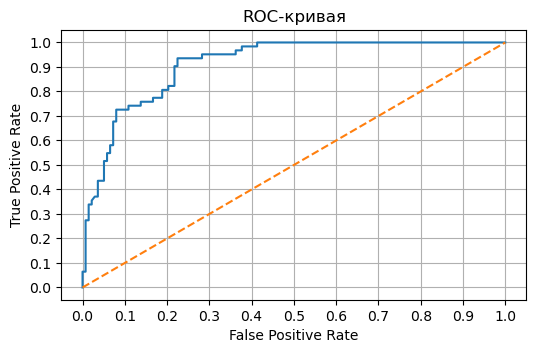

In [17]:
preds = rf.predict(valid_X)
pred_probs= rf.predict_proba(valid_X)

get_result(valid_y, preds, np.array(pred_probs)[:,1])

Точность может быть лучше чем у линейной регрессии, особенно если взять порог 0.4. Как уже было озвучено - порог ниже 0.3 брать нежелательно, даже если там функция показала хороший результат. Немного жертвуя точностью (precision), мы значительно увеличим полноту (recall).

### CatBoostClassifier

Немного изменим функцию выше, для поиска параметров для CatBoost модели, в этот раз необходимо выбрать функцию потерь, установим кросс энтропию.

In [18]:
def get_best_model_cb(train_X, train_y):
    space={'max_depth':[3, 5, 10, 15],
          'l2_leaf_reg':[0.2, 0.7, 1.3],
          'learning_rate': np.arange(0.03, 0.4, .05),
           'iterations': [50,100,150]
          }
    search = RandomizedSearchCV(
        CatBoostClassifier(loss_function='CrossEntropy', random_state=123, verbose=0),
        param_distributions=space,
        scoring='roc_auc',
        random_state=123)
    search.fit(train_X, train_y)
    return search.best_estimator_, search.best_params_

In [19]:
cb, params = get_best_model_cb(train_X, train_y)
print('Лучшие параметры: \n', params)

Лучшие параметры: 
 {'max_depth': 3, 'learning_rate': 0.28, 'l2_leaf_reg': 0.7, 'iterations': 50}


ROC-AUC score = 0.8944600280504909
F1 score = 0.7448275862068965
|---------|---------|--------|--------|
|threshold|precision| recall |f1_score|
|---------|---------|--------|--------|
|   0.1   |  0.43   | 0.984  | 0.598  |
|   0.2   |  0.582  | 0.919  | 0.7125 |
|   0.3   |  0.588  | 0.919  | 0.717  |
|   0.4   |  0.611  | 0.887  | 0.7237 |
|   0.5   |  0.651  | 0.871  | 0.7448 |
|   0.6   |  0.719  | 0.742  | 0.7302 |
|   0.7   |  0.73   | 0.742  | 0.736  |
|   0.8   |  0.775  |  0.5   | 0.6078 |
|---------|---------|--------|--------|


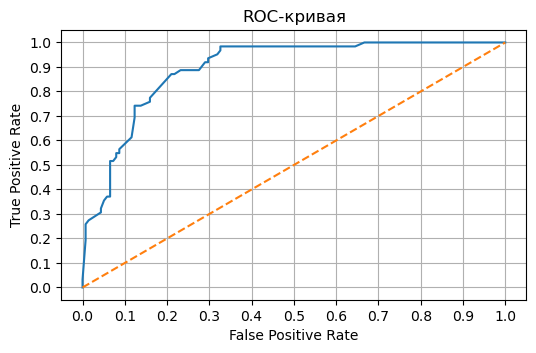

In [20]:
preds = cb.predict(np.array(valid_X, valid_y), prediction_type='Class')
pred_probs = cb.predict(np.array(valid_X, valid_y), prediction_type='Probability')

get_result(valid_y, preds, np.array(pred_probs)[:,1])

Данная модель лучше всех остальных понимает класс единиц, однако точность оставляет желать лучшего. Поэтому выберем в качестве лучшей модели - RandomForestClassifier.

Теперь мы можем оценить, какие признаки оказались наиболее полезными RandomForest для прогнозирования, выведем график:

<AxesSubplot:title={'center':'Feauture importances'}>

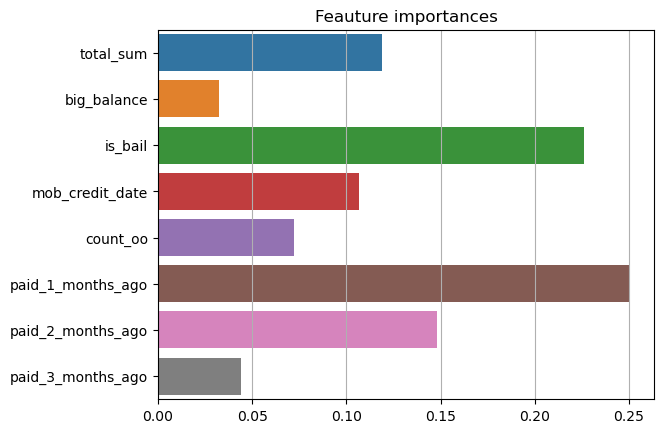

In [21]:
plt.grid()
plt.title('Feauture importances')
sns.barplot(x=rf.feature_importances_, y=train_X.columns)

Как и ожидалось, факт залогового продукта и факт наличия оплаты один-два месяца назад больше всего влияют на результат. Количество времени прошедшее со взятия кредита имеет вес. И новой информацией стало то, что на модель сильнее чем ожидалось повлиял признак общей суммы к оплате.

## Тестирование

Как мы помним, лучшие результаты наша модель должна дать при пороге в 0.4.

Выведем прогноз в виде вероятностей, и вручную сформируем классы учитывая порог.

In [22]:
pred_probs = rf.predict_proba(test_X)
preds = [1 if x >=0.4 else 0 for x in np.array(pred_probs)[:,1]]

In [23]:
print('F1 score =', f1_score(test_y, preds))
print('Precision =', precision_score(test_y, preds))
print('Recall =', recall_score(test_y, preds))
print('ROC_AUC =', roc_auc_score(test_y,np.array(pred_probs)[:,1]))

F1 score = 0.8
Precision = 0.7323943661971831
Recall = 0.8813559322033898
ROC_AUC = 0.9394157951676885


## Подведем итоги

Лучшая модель - RandomForestClassifier, была выбрана по результатам метрик точности, полноты, roc_auc. На пороге 0.4 дает лучшие результаты, а на тестировании:

* F1 = 0.8
* Precision = 0.732
* Recall = 0.88
* Roc_auc = 0.94

Модель успешно справляется с прогнозированием оплаты в течение 30 дней.

По результатам анализа данных и обучению лучше модели, мы выявили наиболее влияющие признаки на прогноз. Признаки убывают по значимости:

1. paid_1_months_ago
2. is_bail
3. paid_2_months_ago
4. total_sum
5. mob_credit_date
6. Все остальные

Также мы выяснили некоторые вещи о клиентах:

1. Когда продукт залоговый, люди с гораздо большей вероятностью оплачивают долг.
2. Если человек платил один-два месяца назад, то есть средняя вероятность что он оплатит долг.
3. Если человек обещает выплату больше 1 раза, есть средняя вероятность что он действительно заплатит.
4. Подавляющее большинство кредитов оплачивается к 70-ти месяцам.